In [2]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Import common GIS tools
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio
from matplotlib.cm import RdYlGn,jet,RdBu

# Import Planetary Computer tools
import stackstac
import pystac_client
import planetary_computer 
from odc.stac import stac_load

#import Machine Learning packages 

import keras
#print('keras: ', keras.__version__)
import  pandas as pd 
import tensorflow as tf 
from sklearn.model_selection import train_test_split


 



In [3]:
# Define the bounding box for the entire data region using (Latitude, Longitude)
# This is the region of New York City that contains our temperature dataset
lower_left = (40.75, -74.01)
upper_right = (40.88, -73.86)


# Calculate the bounds for doing an archive data search
# bounds = (min_lon, min_lat, max_lon, max_lat)
bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])

# Define the time window
time_window = "2021-06-01/2021-09-01"

stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = stac.search(
    bbox=bounds, 
    datetime=time_window,
    collections=["sentinel-2-l2a"],
    query={"eo:cloud_cover": {"lt": 30}},
)

items = list(search.get_items())
print('This is the number of scenes that touch our region:',len(items))

signed_items = [planetary_computer.sign(item).to_dict() for item in items]

#print(signed_items)

# Define the pixel resolution for the final product
# Define the scale according to our selected crs, so we will use degrees
resolution = 10  # meters per pixel 
scale = resolution / 111320.0 # degrees per pixel for crs=4326 

data = stac_load(
    items,
    bands=["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds
)

print(data)



This is the number of scenes that touch our region: 10
<xarray.Dataset> Size: 532MB
Dimensions:      (latitude: 1448, longitude: 1671, time: 10)
Coordinates:
  * latitude     (latitude) float64 12kB 40.88 40.88 40.88 ... 40.75 40.75 40.75
  * longitude    (longitude) float64 13kB -74.01 -74.01 -74.01 ... -73.86 -73.86
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 80B 2021-06-06T15:38:09.024000 ... 202...
Data variables:
    B01          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B02          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B03          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B04          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B05          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.n

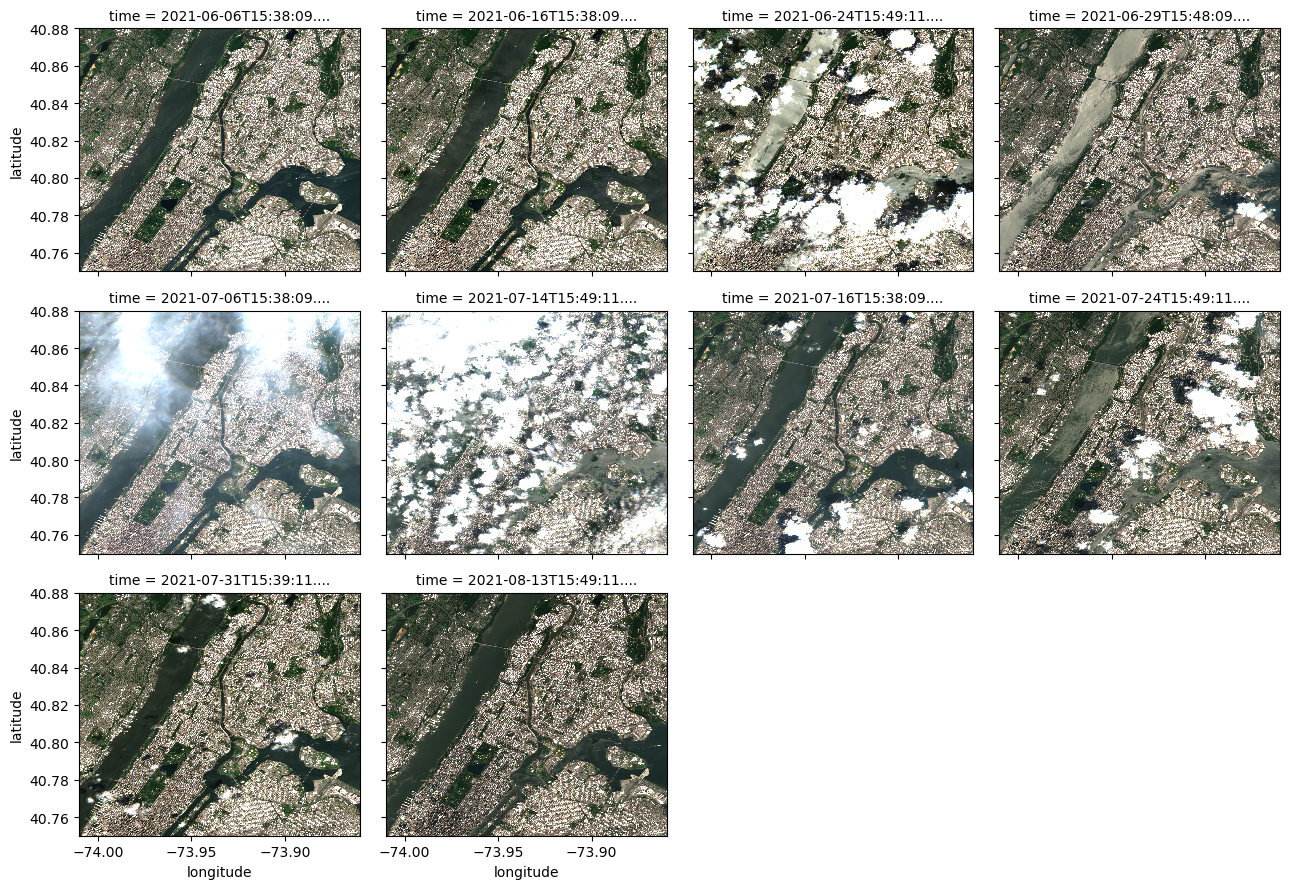

In [4]:
# Plot sample images from the time series
plot_data = data[["B04","B03","B02"]].to_array()
plot_data.plot.imshow(col='time', col_wrap=4, robust=True, vmin=0, vmax=2500)
plt.show()

In [5]:
median = data.median(dim="time").compute()


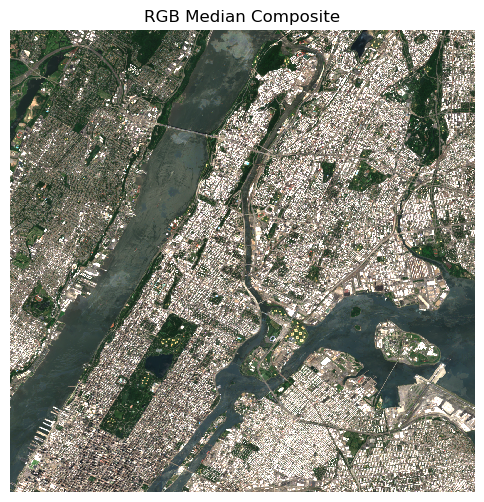

In [6]:

# Plot an RGB image for the median composite or mosaic
# Notice how this new image is void of clouds due to statistical filtering
fig, ax = plt.subplots(figsize=(6,6))
median[["B04", "B03", "B02"]].to_array().plot.imshow(robust=True, ax=ax, vmin=0, vmax=2500)
ax.set_title("RGB Median Composite")
ax.axis('off')
plt.show()

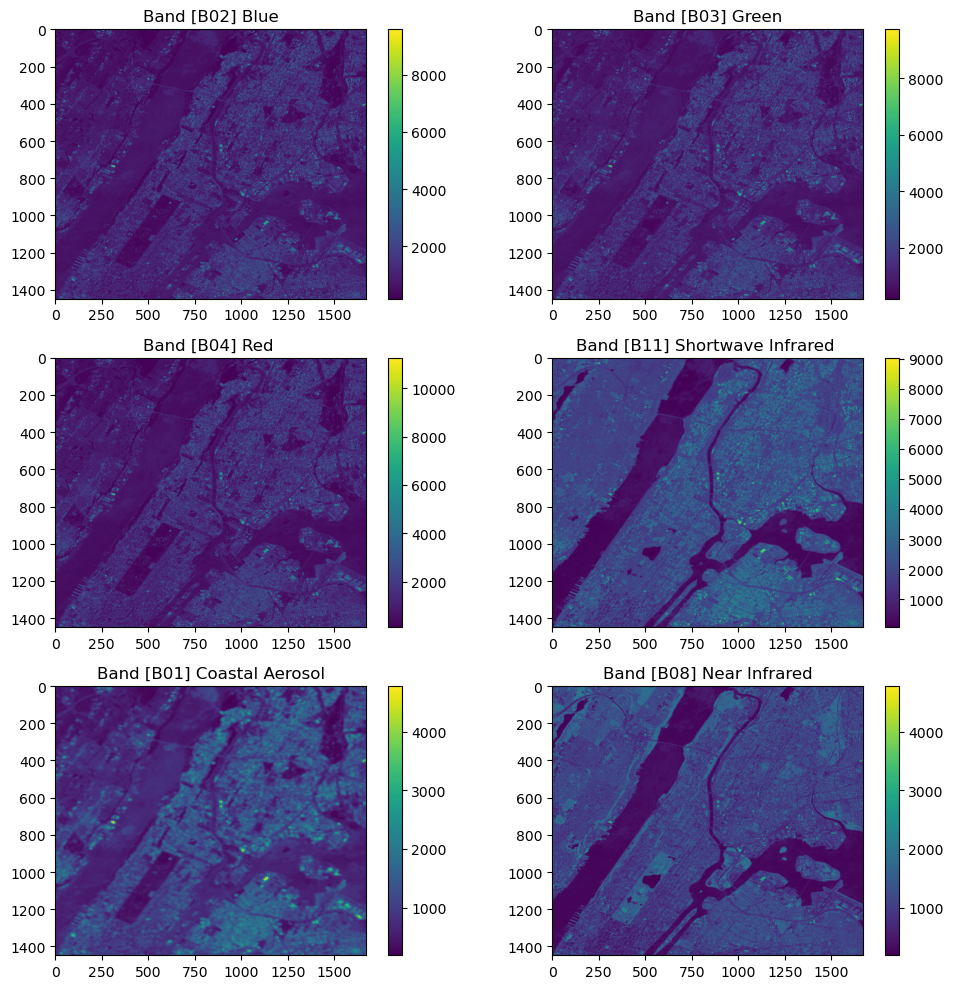

In [7]:
# Plot the bands in a 2x2 grid
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

# Flatten the axes for easier indexing
axes = axes.flatten()

# Plot the first band (B02)
im1 = axes[0].imshow(median["B02"], cmap='viridis')
axes[0].set_title('Band [B02] Blue')
fig.colorbar(im1, ax=axes[0])

# Plot the second band (B03)
im2 = axes[1].imshow(median["B03"], cmap='viridis')
axes[1].set_title('Band [B03] Green')
fig.colorbar(im2, ax=axes[1])

# Plot the third band (B04)
im3 = axes[2].imshow(median["B04"], cmap='viridis')                 
axes[2].set_title('Band [B04] Red ')
fig.colorbar(im3, ax=axes[2])

# Plot the fourth band (B11)
im4 = axes[3].imshow(median["B11"], cmap='viridis')
axes[3].set_title('Band [B11] Shortwave Infrared ')
fig.colorbar(im4, ax=axes[3])


# Plot the fifth band (B01)
im5 = axes[4].imshow(median["B01"], cmap='viridis')
axes[4].set_title('Band [B01] Coastal Aerosol')
fig.colorbar(im5, ax=axes[4])


# Plot the sixth band (B11)
im6 = axes[5].imshow(median["B08"], cmap='viridis')
axes[5].set_title('Band [B08] Near Infrared')
fig.colorbar(im5, ax=axes[5])

plt.tight_layout()
plt.show()


In [ ]:
#Computing the indeces 
ndwi_median = (median.B03-median.B08)/(median.B03+median.B08) #Normalized Difference Water Index
ndbi_median = (median.B11-median.B08)/(median.B11+median.B08) #Normalized Difference Buildup Index
ndvi_median = (median.B08-median.B04)/(median.B08+median.B04) #Normalized Difference Vegetation Index


#data_pd = median.to_dataframe().reset_index()

#data_pd["NDWI"] = (data_pd["B03"] - data_pd["B08"])/(data_pd["B03"] + data_pd["B08"]) #Normalized Difference Water Index
#data_pd["NDBI"] = (data_pd["B11"] - data_pd["B08"])/(data_pd["B11"] + data_pd["B08"]) # Normalized Difference Buildup Index
#data_pd["NDVI"] = (data_pd["B08"] - data_pd["B04"])/(data_pd["B08"] + data_pd["B04"]) #Normalized Difference Vegetation Index
#print(data_pd)


#Adding the indices to the dataset
median["ndwi"] = ndwi_median
median["ndvi"] = ndvi_median
median["ndbi"] = ndbi_median

#print((median))
#median

print(median["ndbi"])

<xarray.DataArray 'ndwi' (latitude: 1448, longitude: 1671)> Size: 19MB
array([[-0.40864714, -0.40864714, -0.48872418, ..., -0.23280056,
        -0.23729904, -0.37185522],
       [-0.38243626, -0.38243626, -0.64827383, ..., -0.27381845,
        -0.31784729, -0.31837223],
       [-0.36410968, -0.36410968, -0.61111111, ..., -0.45607375,
        -0.45031205, -0.48171534],
       ...,
       [ 0.32135028,  0.31640121,  0.31640121, ..., -0.11915413,
        -0.0922538 , -0.0922538 ],
       [ 0.30665507,  0.30584192,  0.30584192, ..., -0.13469985,
        -0.0872211 , -0.0872211 ],
       [ 0.30173913,  0.30951356,  0.30951356, ..., -0.11635028,
        -0.11651962, -0.11651962]])
Coordinates:
  * latitude     (latitude) float64 12kB 40.88 40.88 40.88 ... 40.75 40.75 40.75
  * longitude    (longitude) float64 13kB -74.01 -74.01 -74.01 ... -73.86 -73.86
    spatial_ref  int64 8B 0


In [9]:
filename = "S2_median_fullBands_indeces.tiff"

height = median.dims["latitude"]
width = median.dims["longitude"]

gt = rasterio.transform.from_bounds(lower_left[1],lower_left[0],upper_right[1],upper_right[0],width,height)
median.rio.write_crs("epsg:4326", inplace=True)
median.rio.write_transform(transform=gt, inplace=True)

# Create the GeoTIFF output file using the defined parameters 
with rasterio.open(filename,'w',driver='GTiff',width=width,height=height,
                   crs='epsg:4326',transform=gt,count=14,compress='lzw',dtype='float64') as dst:
    dst.write(median.B01,1)
    dst.write(median.B02,2)
    dst.write(median.B03,3) 
    dst.write(median.B04,4)
    dst.write(median.B05,5)
    dst.write(median.B06,6)
    dst.write(median.B07,7)
    dst.write(median.B08,8)
    dst.write(median.B8A,9)
    dst.write(median.B11,10)
    dst.write(median.B12,11)
    dst.write(median.ndwi,12)
    dst.write(median.ndvi,13)
    dst.write(median.ndbi,14)
    dst.close()

In [10]:
!ls *.tiff

S2_median_fullBands_indeces.tiff


In [11]:
#print(data_pd)
"""
# Plot the bands in a 2x2 grid
fig, axes = plt.subplots(3, 1, figsize=(10, 10))

# Flatten the axes for easier indexing
axes = axes.flatten()


# Plot the NDWI
im1 = axes[0].imshow(data_pd["B02"], vmin=-0.3, vmax=0.3, cmap="RdBu")
axes[0].set_title('Band [B02] Blue')
fig.colorbar(im1, ax=axes[0])

# Plot the NDVI
im2 = axes[1].imshow(data_pd["NDVI"],vmin=0.0, vmax=1.0, cmap="RdYlGn")
axes[1].set_title('Band [B03] Green')
fig.colorbar(im2, ax=axes[1])

# Plot the NDBI
im3 = axes[2].imshow(data_pd["NDBI"], vmin=-0.1, vmax=0.1, cmap="jet")                 
axes[2].set_title('Band [B04] Red ')
fig.colorbar(im3, ax=axes[2])
###

#this part doest quite work, have to reshape the data_pd columns into 2d images I guess, for some reason xarray does this automatically.
"""




'\n# Plot the bands in a 2x2 grid\nfig, axes = plt.subplots(3, 1, figsize=(10, 10))\n\n# Flatten the axes for easier indexing\naxes = axes.flatten()\n\n\n# Plot the NDWI\nim1 = axes[0].imshow(data_pd["B02"], vmin=-0.3, vmax=0.3, cmap="RdBu")\naxes[0].set_title(\'Band [B02] Blue\')\nfig.colorbar(im1, ax=axes[0])\n\n# Plot the NDVI\nim2 = axes[1].imshow(data_pd["NDVI"],vmin=0.0, vmax=1.0, cmap="RdYlGn")\naxes[1].set_title(\'Band [B03] Green\')\nfig.colorbar(im2, ax=axes[1])\n\n# Plot the NDBI\nim3 = axes[2].imshow(data_pd["NDBI"], vmin=-0.1, vmax=0.1, cmap="jet")                 \naxes[2].set_title(\'Band [B04] Red \')\nfig.colorbar(im3, ax=axes[2])\n###\n\n#this part doest quite work, have to reshape the data_pd columns into 2d images I guess, for some reason xarray does this automatically.\n'

In [12]:

'''
#Split training and testing dataset.
UHI_filepath = "/Users/jorgehernandez/Desktop/COS513/CourseProject/Code/Data/Training_data_uhi_index_2025-02-18.csv"
UHI_data = pd.read_csv(UHI_filepath)

#rename the data_pd column from latitude to Latitude and same for longitude 

data_pd= data_pd.rename(columns={'longitude': 'Longitude', 'latitude': 'Latitude'})
final_data = pd.merge(data_pd, UHI_data, on=['Latitude', 'Longitude'], how='inner')

#y = data_pd[" "]
#train_test_split()

#final_data
final_data
''' 

'\n#Split training and testing dataset.\nUHI_filepath = "/Users/jorgehernandez/Desktop/COS513/CourseProject/Code/Data/Training_data_uhi_index_2025-02-18.csv"\nUHI_data = pd.read_csv(UHI_filepath)\n\n#rename the data_pd column from latitude to Latitude and same for longitude \n\ndata_pd= data_pd.rename(columns={\'longitude\': \'Longitude\', \'latitude\': \'Latitude\'})\nfinal_data = pd.merge(data_pd, UHI_data, on=[\'Latitude\', \'Longitude\'], how=\'inner\')\n\n#y = data_pd[" "]\n#train_test_split()\n\n#final_data\nfinal_data\n'

In [13]:
!pwd

UnboundLocalError: local variable 'child' referenced before assignment